# This code runs bfastmonitor over an entire time series data set

In [1]:
import os
from os.path import expanduser

import wget
import numpy as np
from datetime import datetime
import copy
import matplotlib
import matplotlib.pyplot as plt

import json

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal, gdal_array, osr

import time
from tqdm import tqdm

import ipywidgets as widgets
from ipywidgets import Layout
from ipyfilechooser import FileChooser
import folium

from PIL import Image
from matplotlib import cm

# import functions from functions.py
from functions import set_base_output_dir, set_output_dir, get_data_dict, merge_tiles, set_paths, _find_index_date, normalize 
from plotting_funcs import save_plot, merge_plots, classify_output, plot_output_matplotlib, set_corners

# Import the Timeseries class from time_series.py
from time_series import Timeseries
print(Timeseries.__doc__)

# Import widgets for GUI parameter selection
from widgets import get_widgets, get_dates_widgets
output_directory_chooser, k_chooser,freq_chooser,trend_chooser,hfrac_chooser,level_chooser,backend_chooser, load_chooser, block_size_chooser, plot_display_data_chooser = get_widgets()


    The timeseries class is a wrapper for using SEPAL timeseries data with bfast. 
    It wraps together a data tile with associated dates file and metadata. 
    It also allows for saving and loading the output rasters in a specified directory. 
    


In [2]:
%matplotlib inline

In [3]:
display(output_directory_chooser)

interactive(children=(Text(value='', description='Output storage name: (country/location name, e.g. "Guyana")'…

In [4]:
base_output_dir = set_base_output_dir(output_directory_chooser)

Output directory name: stored_time_series/Portugal_small


# Select your timeseries folder

In [5]:
path = expanduser("~")
file_chooser = FileChooser(path)
display(file_chooser)

FileChooser(path='/home/dven', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden…

In [6]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)
    #output_dir = set_output_dir(output_directory_chooser,timeseries_directory)
    #print(output_dir)

/home/dven/downloads/Time_series_2020-07-07_11-51-35_Portugal/


In [7]:
# set path to dates file
run_dict = {}
for directory in os.listdir(timeseries_directory):
    
    segment_location = timeseries_directory + directory + "/"
    
    data_list = set_paths(timeseries_directory = segment_location)
    
    run_dict[directory] = data_list
    
    for tile in data_list:
        print(tile)

No tiles, setting up data as one tile
Timeseries class holding 529 dates, sized 14 by 8.


In [8]:
for data_list in run_dict.values():
    print(data_list)


[Timeseries: /home/dven/downloads/Time_series_2020-07-07_11-51-35_Portugal/1/stack.vrt ]


In [9]:
# Choose parameters
display(k_chooser)
display(freq_chooser)
display(trend_chooser)
display(hfrac_chooser)
display(level_chooser)
display(backend_chooser)

interactive(children=(Dropdown(description='k, harmonic terms', index=2, layout=Layout(height='auto', width='5…

interactive(children=(IntSlider(value=365, description='freq, frequency of seasonal model (days)', layout=Layo…

interactive(children=(Checkbox(value=True, description='add trend', layout=Layout(height='auto', width='500px'…

interactive(children=(FloatSlider(value=0.25, description='Bandwith relative to sample size', layout=Layout(he…

interactive(children=(SelectionSlider(description='Significance level of the monitoring', layout=Layout(height…

interactive(children=(Dropdown(description='backend', layout=Layout(height='auto', width='500px'), options=('o…

In [10]:
# Set parameters
k = k_chooser.result
freq = freq_chooser.result
trend = trend_chooser.result
hfrac = hfrac_chooser.result
level = 1 - level_chooser.result
backend = backend_chooser.result
verbose = 1
device_id = 0

In [11]:
dates = data_list[0].dates
start_date = dates[0] # 0 or 10 does not work.. 100 did ########
end_date = dates[-1]
pandas_dates = pd.date_range(start_date, end_date, freq='D')

options =  [(date.strftime('%Y-%m-%d'),date) for date in pandas_dates]
index = (0, len(options)-1)

monitoring_period_chooser, history_period_chooser = get_dates_widgets(options = options, index = index)

display(monitoring_period_chooser)
display(history_period_chooser)

interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 7456), …

interactive(children=(SelectionSlider(description='Start history period:', options=(('2000-01-08', Timestamp('…

In [12]:
start_monitor, end_monitor = monitoring_period_chooser.result
start_hist = history_period_chooser.result

if history_period_chooser.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")
if start_monitor < dates[50]:
    raise Warning("Your history period is relatively short, did you move the monitoring date range to a later date?")




In [13]:
display(block_size_chooser)

interactive(children=(Dropdown(description='block size, bigger is generally faster, but may result in memory i…

In [14]:
x_block = y_block = block_size_chooser.result


for data_list in run_dict:
    # loading bar
    with tqdm(total=len(data_list)) as pbar1:
        
        
        save_location = base_output_dir + "/" + data_list
        if not os.path.exists(save_location):
            os.makedirs(save_location)
        

        # loop over tile(s) in the data_list
        for counter, tile in enumerate(run_dict[data_list]):
            pbar1.set_description("Processing tile %s out of %s" % (counter+1, len(data_list)) )

            tile.set_bfast_parameters(start_monitor = start_monitor, 
                                         end_monitor = end_monitor,
                                         start_hist = start_hist,
                                         freq = freq,
                                         k = k,
                                         hfrac = hfrac,
                                         trend = trend,
                                         level = level,
                                         backend=backend,
                                         verbose=verbose,
                                         device_id=device_id)

            tile.get_bfast_parameters()

            tile.loop_blocks(x_block_size = x_block,
                                y_block_size=y_block)

            tile.log_all_output(output_dir_name=save_location)

            pbar1.update(counter)

    pbar1.close()

    # Store the cropped dates for optional loading later
    with open(save_location + "/cropped_dates.csv","w") as f:
        for date in run_dict[data_list][0].cropped_dates:
            f.write(date.strftime("%m/%d/%Y"))
            f.write("\n")


Processing tile 1 out of 1:   0%|          | 0/1 [00:00<?, ?it/s]
  0%|          | 0/0.001708984375 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/0.001708984375 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x310f670>]
Monitoring starts at:  2012-03-06 00:00:00
Monitoring ends at:  2020-06-07 00:00:00
Dataset history starts at:  2000-01-08 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  True
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  14 8
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [14, 8]
set blocksize explicitly:  256 ,  256
start monitor:  2012-03-06 00:00:00
end monitor:  2020-06-07 00:00:00
start history:  2000-01-08 00:00:00
0 0 14 8


Processing blocks of tile:: : 1it [00:02,  2.69s/it]                          
Processing tile 1 out of 1:   0%|          | 0/1 [00:02<?, ?it/s]

--- runtime for data initialization:		0.0022139549255371094
--- runtime for data transfer (host->device):	0.00019669532775878906
--- runtime for data preprocessing:		0.00037789344787597656
--- runtime for kernel execution:		0.0018956661224365234
--- runtime for data transfer (device->host):	0.0002219676971435547
Fitting model over all blocks took 2.6925477981567383 seconds.


minus2s:  0
minus1s:  80
total 112
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 28.57142857142857
amount of nans in means:  96
{2012: 0, 2013: 9, 2014: 38, 2015: 70, 2016: 111, 2017: 152, 2018: 191, 2019: 225, 2020: 262}


/home/dven/bfastmonitor_cpu/dven/plotting_funcs.py:127: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)


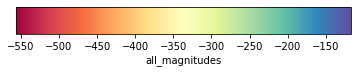

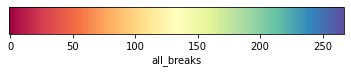

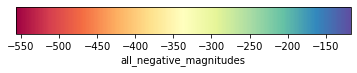

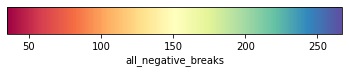

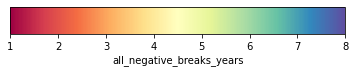

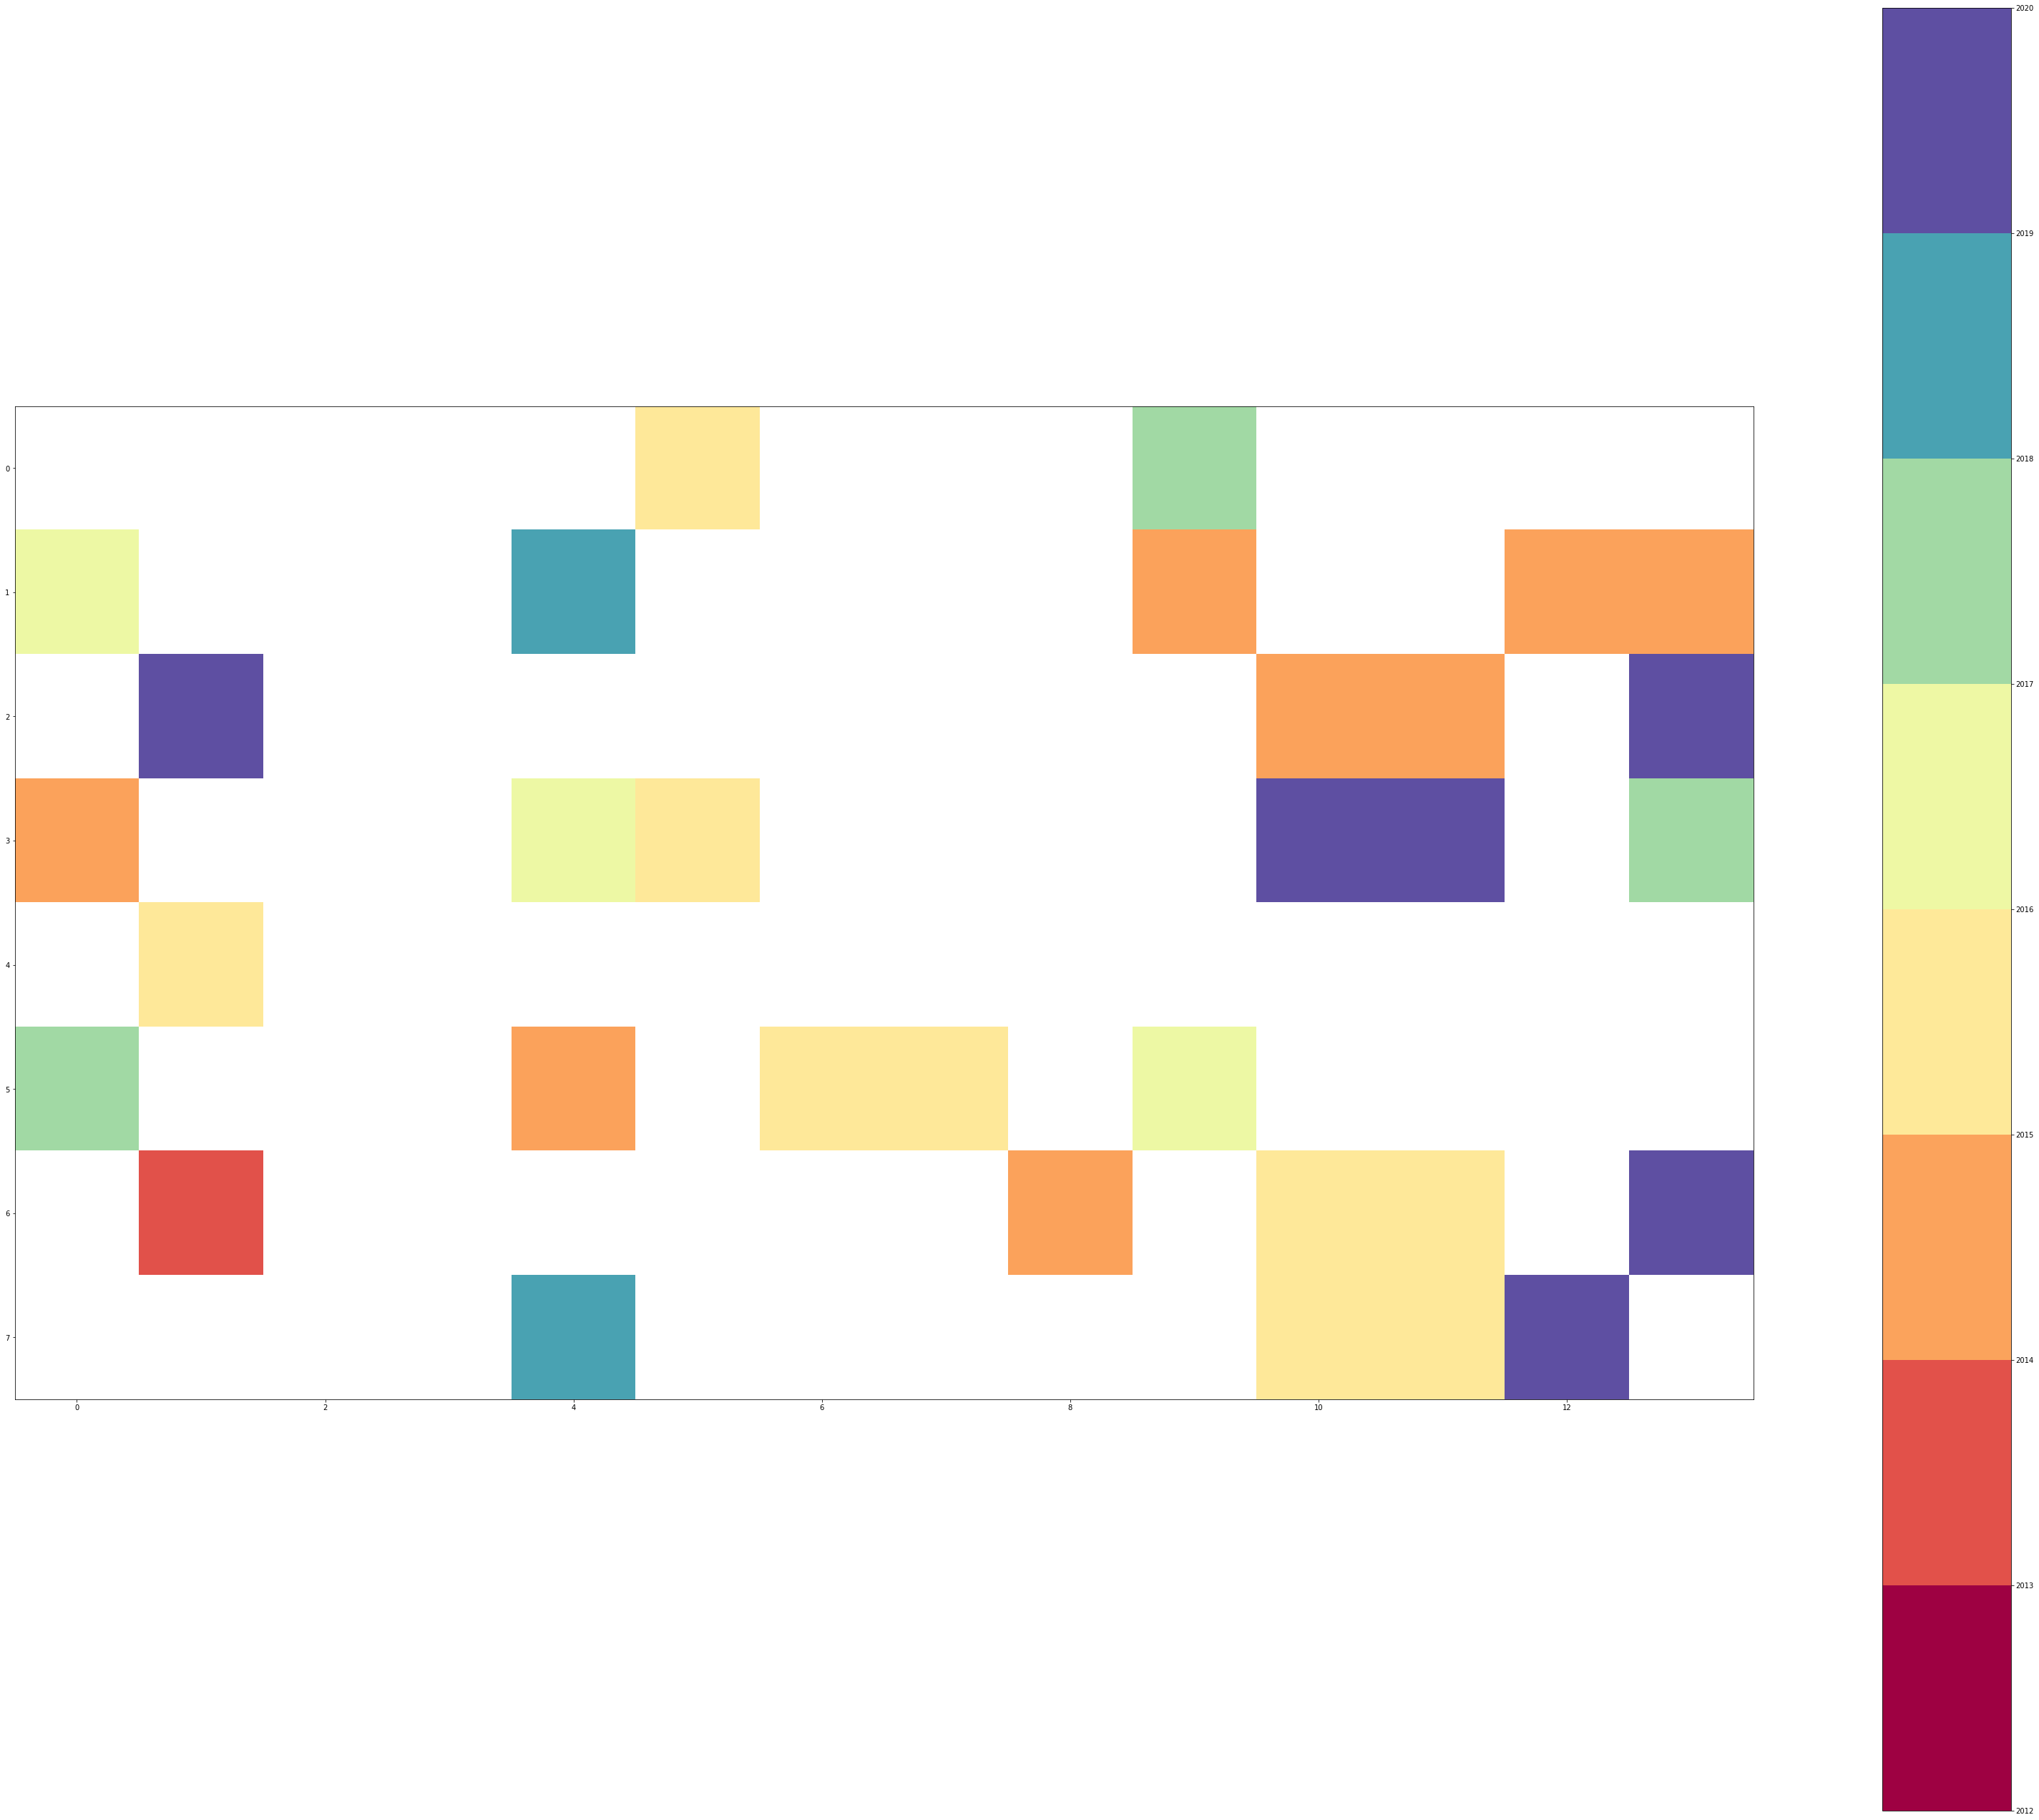

min_lat  40.701497713586164
max_lat  40.701497713586164
min_lon  -8.420088821109099
max_lon  -8.420088821109099


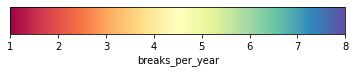

In [16]:
for data_list in run_dict:
    save_location = base_output_dir + "/" + data_list
    
    for tile in run_dict[data_list]:
        tile.check_arrays(min_perc_lacking_data = 50)
    
    if len(run_dict[data_list]) > 1:
        big_means_array, big_breaks_array = merge_tiles(run_dict[data_list],output_dir_name = save_location)
    
    if len(run_dict[data_list])>1:
        means = big_means_array
        breaks = big_breaks_array
    else:
        means = run_dict[data_list][0].means_array
        breaks = run_dict[data_list][0].breaks_array
    
    save_plot(means, save_location, save_name = "all_magnitudes")
    save_plot(breaks, save_location, save_name = "all_breaks")
    
    # select only negative magnitudes
    no_breaks_indices = (breaks == -1)
    means[no_breaks_indices] = np.nan
    means[means > 0] = np.nan # only want negative mean changes

    breaks_plot = breaks.astype(np.float)
    breaks_plot[breaks == -2] = np.nan
    breaks_plot[breaks == -1] = np.nan
    breaks_plot[means >= 0] = np.nan

    save_plot(means, save_location, save_name = "all_negative_magnitudes")
    save_plot(breaks_plot, save_location, save_name = "all_negative_breaks")

    dates_monitor = []
    dates = run_dict[data_list][0].cropped_dates

    # collect dates for monitor period
    for i in range(len(dates)):
        if start_monitor <= dates[i]:
            dates_monitor.append(dates[i])
    dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period
    
    breaks_plot_years, idx_starts, ticklist = classify_output(start_monitor,end_monitor,breaks_plot,dates_array)
    save_plot(breaks_plot_years, save_location, save_name = "all_negative_breaks_years")
    
    plot_output_matplotlib(idx_starts,breaks_plot_years,ticklist)
    save_plot(breaks_plot_years, save_location, save_name = "breaks_per_year")
    
    set_corners(save_location, run_dict[data_list])
    
    
    

In [17]:
display(plot_display_data_chooser)

interactive(children=(Dropdown(description='data to plot', index=1, layout=Layout(height='auto', width='500px'…

In [18]:
from folium.plugins import FloatImage
import base64

import json

m = merge_plots(base_output_dir=base_output_dir,plot_name=plot_display_data_chooser.result + ".png")


####
# resolution, width, height = 75, 4,4
# encoded = base64.b64encode(open("output/testcolorbar.png", 'rb').read()).decode()
# from folium import IFrame

# html = '<img src="data:image/png;base64,{}">'.format
# iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)
# popup = folium.Popup(iframe, max_width=2650)

# icon = folium.Icon(color="red", icon="ok")
# marker = folium.Marker([data_list[0].latitude, data_list[0].longitude], popup=popup, icon=icon)
# marker.add_to(m)
####


#m.save('output/' + output_directory_chooser.result + "_" + plot_display_data_chooser.result + ".html")
m

Portugal_small_1
1
